In [ ]:
!pip install textblob
!python -m textblob.download_corpora


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
import pandas as pd
from textblob import TextBlob
from tqdm import tqdm

# Load IMDb dataset (adjust path if needed)
df = pd.read_csv("/IMDB Dataset.csv")

# Define a function to classify sentiment using TextBlob
def classify_sentiment(text):
    analysis = TextBlob(text).sentiment.polarity  # Get polarity score (-1 to 1)
    if analysis > 0.2:
        return "positive"  # Positive sentiment
    elif analysis < -0.2:
        return "negative"  # Negative sentiment
    else:
        return "neutral"  # Newly added class

# Apply classification to all reviews
tqdm.pandas()  # Enable progress bar for large datasets
df["sentiment"] = df["review"].progress_apply(classify_sentiment)

# Convert labels to numeric format
df["label"] = df["sentiment"].map({"negative": 0, "neutral": 1, "positive": 2})

# Print new label distribution
print("Class Distribution after relabeling:")
print(df["label"].value_counts())

# Save the new dataset
df.to_csv("IMDB_Multiclass_Dataset.csv", index=False)
print("✅ Saved the modified dataset with neutral sentiment!")


100%|██████████| 50000/50000 [01:48<00:00, 461.50it/s]


Class Distribution after relabeling:
label
1    35448
2    12845
0     1707
Name: count, dtype: int64
✅ Saved the modified dataset with neutral sentiment!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [ ]:
# Load IMDb dataset (after adding neutral sentiment)
df = pd.read_csv("IMDB_Multiclass_Dataset.csv")

In [ ]:
# Check dataset structure
print(df.head())
print("Class Distribution:")
print(df['sentiment'].value_counts())

                                              review sentiment  label
0  One of the other reviewers has mentioned that ...   neutral      1
1  A wonderful little production. <br /><br />The...   neutral      1
2  I thought this was a wonderful way to spend ti...  positive      2
3  Basically there's a family where a little boy ...   neutral      1
4  Petter Mattei's "Love in the Time of Money" is...  positive      2
Class Distribution:
sentiment
neutral     35448
positive    12845
negative     1707
Name: count, dtype: int64


In [ ]:
# Convert labels to numerical values (0=Negative, 1=Neutral, 2=Positive)
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['sentiment'] = df['sentiment'].map(label_mapping)

In [ ]:
# Text Vectorization using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X = vectorizer.fit_transform(df['review'])
y = df['label']

In [ ]:
# Split dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Train Multinomial Naïve Bayes Model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mnb_preds = mnb.predict(X_test)
mnb_proba = mnb.predict_proba(X_test)  # Predicted probabilities


In [ ]:
# Train Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)

In [ ]:
# Convert labels to One-Hot Encoding for AUC calculation
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_test_encoded = encoder.fit_transform(np.array(y_test).reshape(-1, 1))

In [ ]:
# Define evaluation function
def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"\n📊 Model Performance: {model_name}\n")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("F1-score:", f1_score(y_true, y_pred, average='weighted'))
    auc_score = roc_auc_score(y_test_encoded, y_proba, average='weighted', multi_class='ovr')
    print("AUC:", auc_score)

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


📊 Model Performance: Multinomial Naïve Bayes

Accuracy: 0.7652
Precision: 0.7467850756748323
Recall: 0.7652
F1-score: 0.7160288072342045
AUC: 0.8210475923363505


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


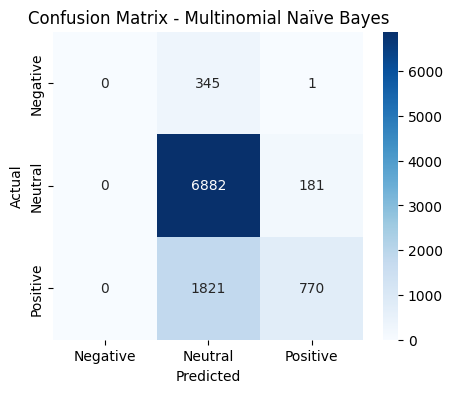


📊 Model Performance: Random Forest

Accuracy: 0.794
Precision: 0.810063108569723
Recall: 0.794
F1-score: 0.7582404752317198
AUC: 0.8571525707992852


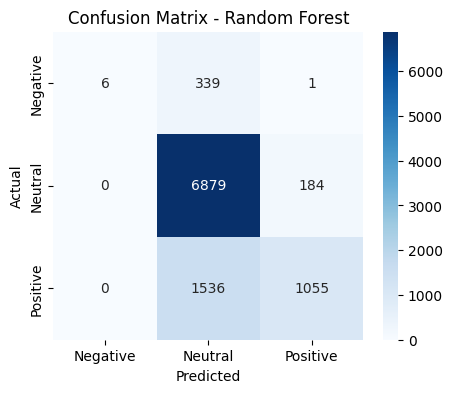

In [ ]:
# Evaluate both models
evaluate_model(y_test, mnb_preds, mnb_proba, "Multinomial Naïve Bayes")
evaluate_model(y_test, rf_preds, rf_proba, "Random Forest")

In [ ]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from tqdm import tqdm  # Import tqdm for progress bar


In [ ]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
# Load Modified IMDb Dataset
df = pd.read_csv("/content/IMDB_Multiclass_Dataset.csv")  # Ensure dataset includes neutral sentiment


In [ ]:
# Map sentiment labels to integers
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment'] = df['sentiment'].map(label_mapping)


In [ ]:
# Load DistilBERT Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize(text, max_len=100):
    encoding = tokenizer(text, padding='max_length', truncation=True, max_length=max_len, return_tensors='pt')
    return encoding

class IMDbDataset(Dataset):
    def __init__(self, texts, labels, max_len=100):
        self.encodings = [tokenize(text, max_len) for text in texts]
        self.labels = labels

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        item = {key: val.squeeze(0) for key, val in self.encodings[idx].items()}
        item['label'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [106]:
# Split Data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'].tolist(), df['sentiment'].tolist(), test_size=0.2, random_state=42, stratify=df['sentiment']
)

train_dataset = IMDbDataset(train_texts, train_labels)
test_dataset = IMDbDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [107]:
# Define DistilBERT Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3).to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training Loop
def train_model(model, train_loader, epochs=2):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for batch in progress_bar:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            progress_bar.set_postfix(loss=total_loss / len(train_loader))
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

train_model(model, train_loader)

Epoch 1:   2%|▏         | 56/2500 [09:23<6:30:04,  9.58s/it, loss=0.0151]

In [ ]:
# Split Data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['review'].tolist(), df['sentiment'].tolist(), test_size=0.2, random_state=42, stratify=df['sentiment']
)
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Now pass the tokenizer to IMDbDataset
train_dataset = IMDbDataset(train_texts, train_labels, tokenizer)
test_dataset = IMDbDataset(test_texts, test_labels, tokenizer)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



In [ ]:
for batch in train_loader:
    print(f"Batch keys: {batch.keys()}")
    break


AttributeError: 'IMDbDataset' object has no attribute 'texts'

In [ ]:
# Define BiLSTM Model
"""
class BiLSTM(nn.Module):
    def __init__(self, embedding_dim=100, hidden_dim=64, num_layers=1, num_classes=3):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(self.dropout(lstm_out[:, -1, :]))
        return output
"""
class BiLSTM(nn.Module):
    def __init__(self, embedding_dim=768, hidden_dim=128, num_layers=2, num_classes=3):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(0.5)


    def forward(self, input_ids, attention_mask=None):  # Accept attention_mask but ignore it
        lstm_out, _ = self.lstm(input_ids)  # Only use input_ids
        output = self.fc(self.dropout(lstm_out[:, -1, :]))
        return output




In [ ]:
# Initialize Model
model = BiLSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Training Loop
def train_model(model, train_loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")  # Add progress bar

        for batch in progress_bar:
            optimizer.zero_grad()

            # Ensure correct key access and dtype
            input_ids = batch['input_ids'].to(device).float()  # Explicitly set float type
            labels = batch['label'].to(device)

            outputs = model(input_ids)  # Pass only input_ids
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            progress_bar.set_postfix(loss=total_loss / len(train_loader))  # Update progress bar

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

train_model(model, train_loader)


Epoch 1:   0%|          | 0/2500 [00:00<?, ?it/s]


KeyError: 'Invalid key. Only three types of key are available: (1) string, (2) integers for backend Encoding, and (3) slices for data subsetting.'

In [ ]:
# Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(pd.get_dummies(all_labels), np.array(all_probs), multi_class='ovr')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    print(f"AUC: {auc}")

evaluate_model(model, test_loader)


Accuracy: 0.7652
Precision: 0.7550790646861874
Recall: 0.7652
F1-score: 0.7578465696582852
AUC: 0.8236038748857921
